In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,BatchNormalization, Flatten, Dense, Dropout

In [ ]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/brain tumor MRI classification','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/brain tumor MRI classification','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:30<00:00,  2.43it/s]


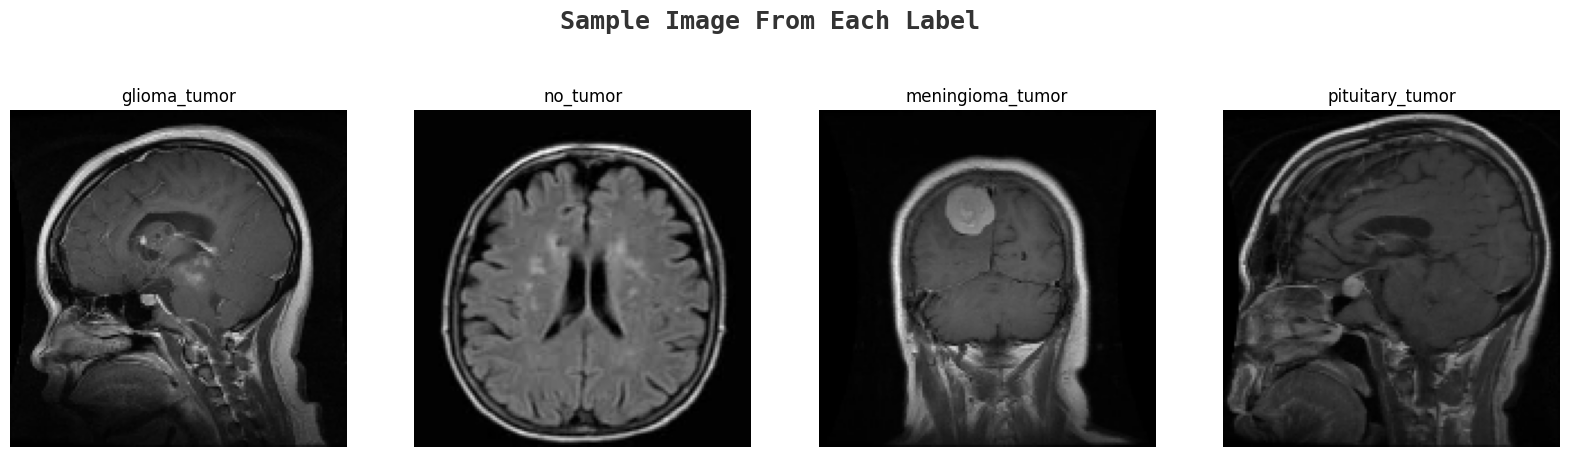

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
X_train.shape

(2937, 150, 150, 3)

In [ ]:
X_test.shape

(327, 150, 150, 3)

In [ ]:
y_train.shape

(2937,)

In [ ]:
y_test.shape

(327,)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)

# Find unique class labels
unique_labels = np.unique(y_test_labels)

print("Unique class labels:", unique_labels)

Unique class labels: [0 1 2 3]


In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.787384 to fit



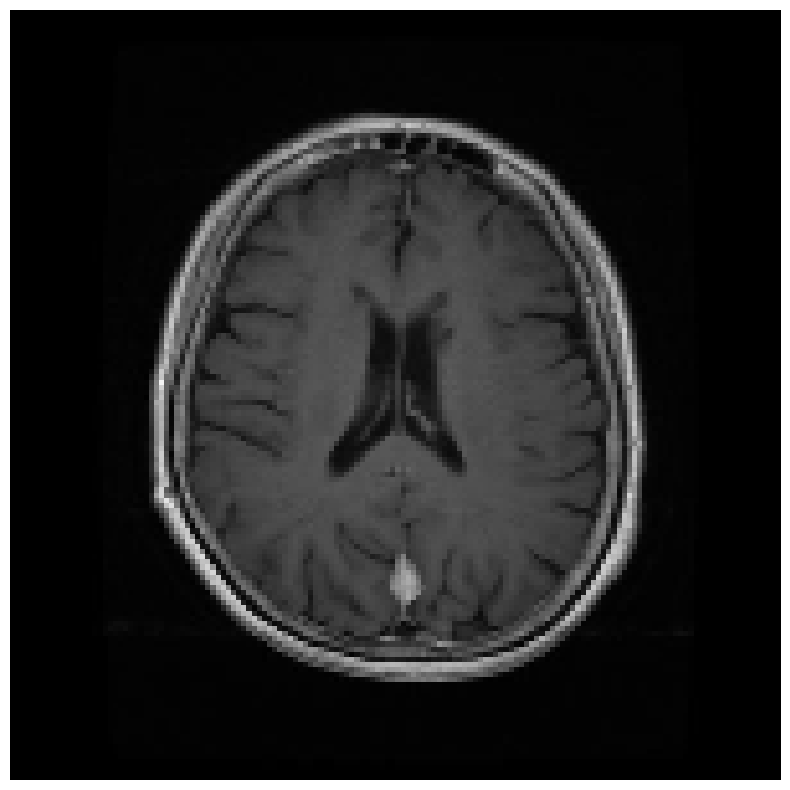

In [ ]:
plot_model(model, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.4571 - accuracy: 0.8347
Epoch 1: val_accuracy improved from -inf to 0.86735, saving model to effnet.keras
83/83 [==============================] - 58s 195ms/step - loss: 0.4571 - accuracy: 0.8347 - val_loss: 0.4805 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9474
Epoch 2: val_accuracy improved from 0.86735 to 0.89796, saving model to effnet.keras
83/83 [==============================] - 12s 141ms/step - loss: 0.1677 - accuracy: 0.9474 - val_loss: 0.5134 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9610
Epoch 3: val_accuracy improved from 0.89796 to 0.94218, saving model to effnet.keras
83/83 [==============================] - 13s 159ms/step - loss: 0.1075 - accuracy: 0.9610 - val_loss: 0.2376 - val_accuracy: 0.9422 - lr: 0.0010
Epoch 4/5
83/83 [=================

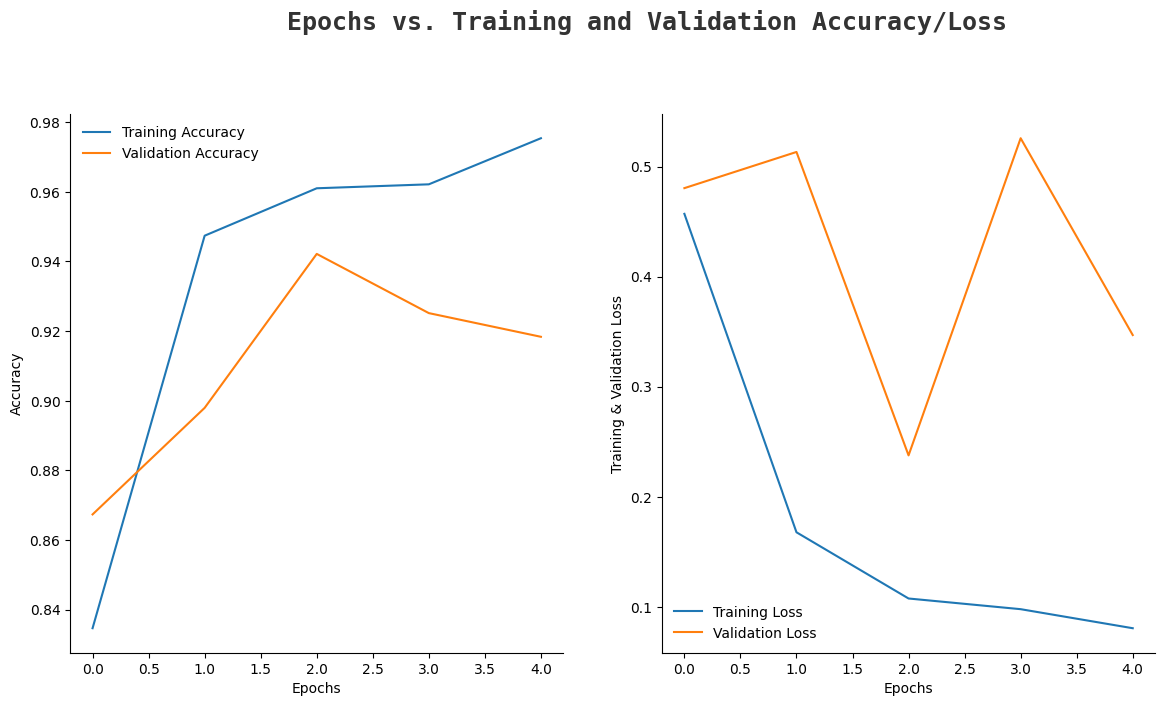

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 4s 163ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91        97
           1       0.98      0.96      0.97        48
           2       0.99      0.83      0.90       101
           3       0.96      0.96      0.96        81

    accuracy                           0.93       327
   macro avg       0.94      0.94      0.94       327
weighted avg       0.94      0.93      0.93       327



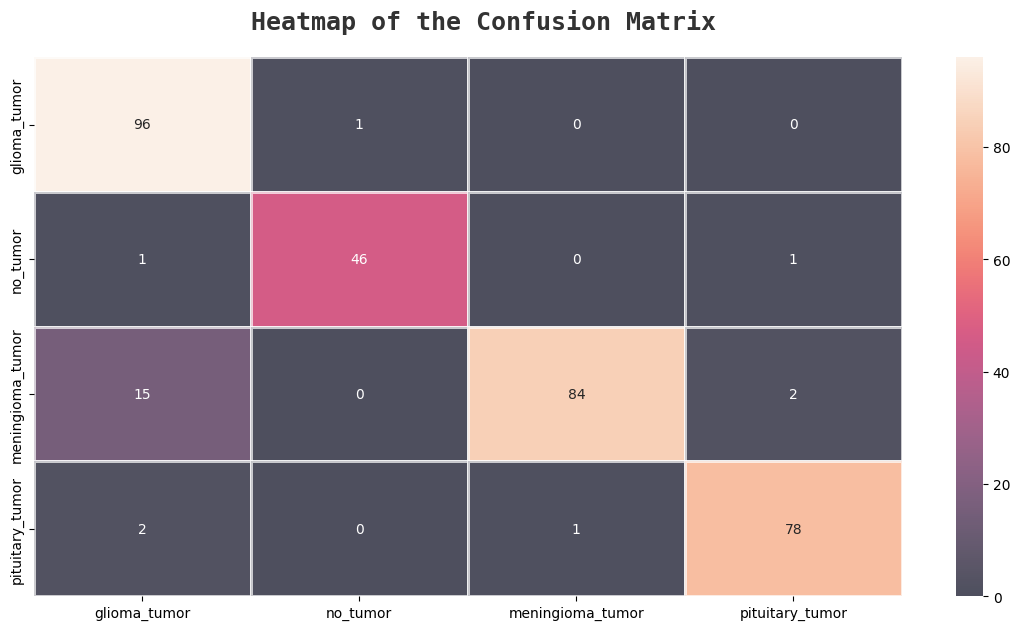

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

**model**

In [ ]:
model_cnn=Sequential()
model_cnn.add(Input(shape=(224,224,3)))
model_cnn.add(Conv2D(128,(3,3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(64,(3,3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(32,(3,3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Flatten())
model_cnn.add(Dense(128,activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(64,activation='relu'))
model_cnn.add(Dense(4,activation='softmax'))
model_cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 111, 111, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,769,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,874,276 (10.96 MB)

 Trainable params: 2,873,828 (10.96 MB)

 Non-trainable params: 448 (1.75 KB)

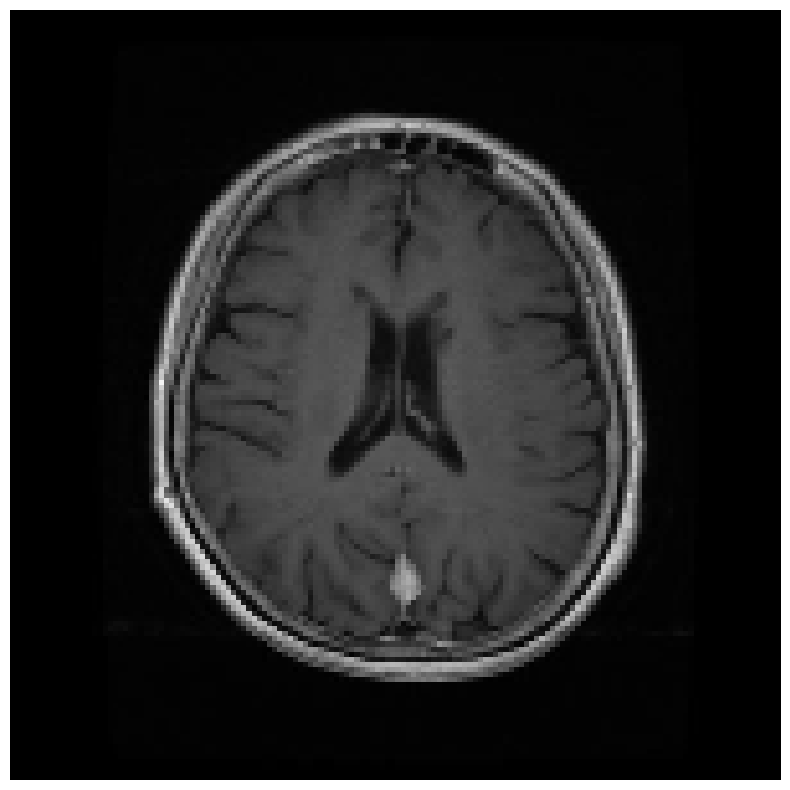

In [ ]:
plot_model(model_cnn, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
resized_X_train = []
for img in X_train:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_train.append(resized_img)

resized_X_train = np.array(resized_X_train)

resized_X_test = []
for img in X_test:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_test.append(resized_img)

resized_X_test = np.array(resized_X_test)

In [ ]:
model_cnn.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
# Import the necessary callback
from tensorflow.keras.callbacks import TensorBoard

# Assuming 'checkpoint' and 'reduce_lr' are defined elsewhere,
# instantiate the TensorBoard callback
tensorboard = TensorBoard(log_dir='./logs') # Adjust log directory as needed

history = model_cnn.fit(resized_X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

NameError: name 'checkpoint' is not defined

In [ ]:
history = model_cnn.fit(resized_X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

NameError: name 'tensorboard' is not defined

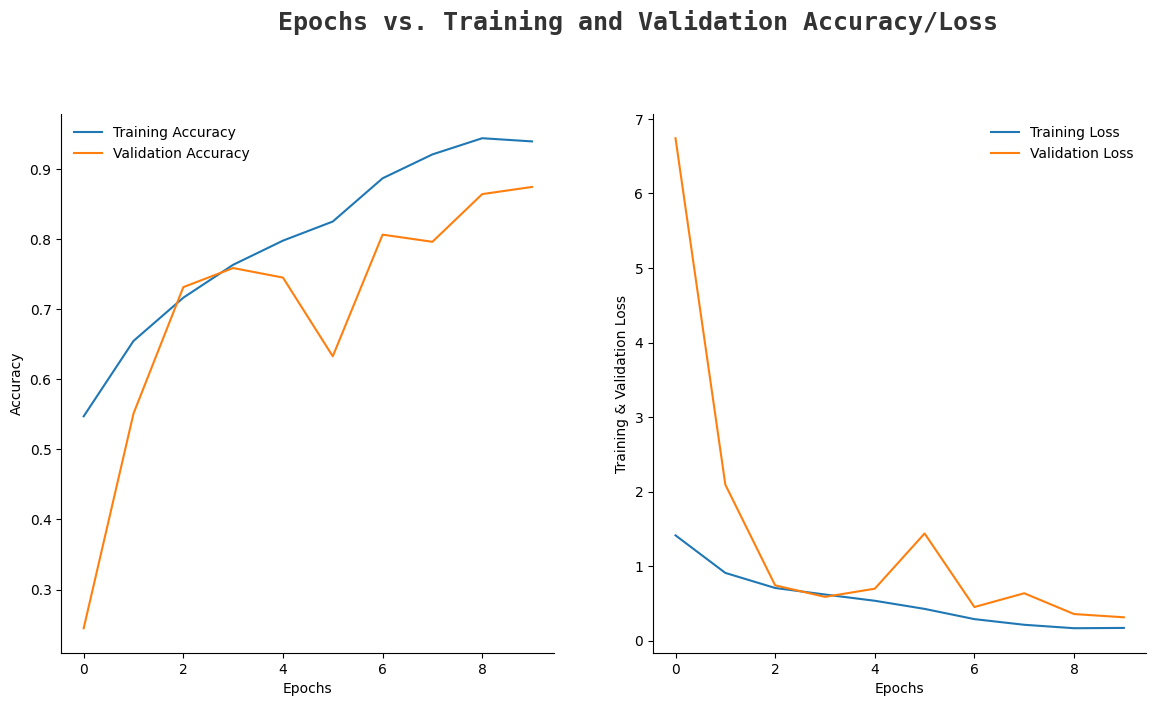

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model_cnn.predict(resized_X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 1s 82ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        97
           1       0.93      0.83      0.88        48
           2       0.78      0.89      0.83       101
           3       0.95      0.99      0.97        81

    accuracy                           0.88       327
   macro avg       0.90      0.88      0.88       327
weighted avg       0.89      0.88      0.88       327



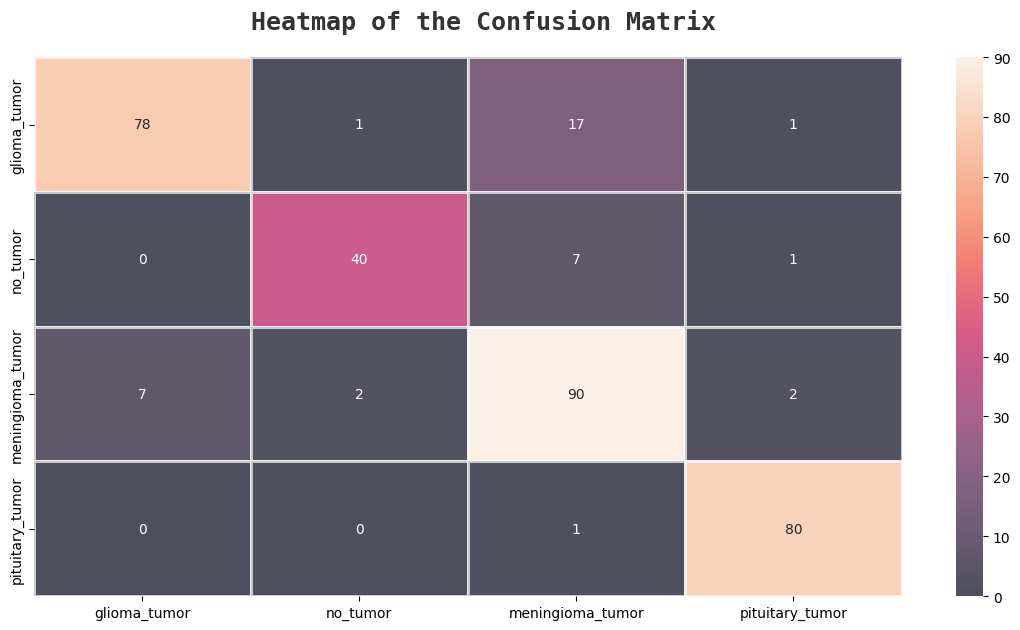

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

In [ ]:
model.save("/content/drive/MyDrive/BTD_MRI_Model/brain_cnn.h5")